In [17]:
# autoreload
%load_ext autoreload
%autoreload 2


In [ ]:
from utils.pianoroll import PianoRoll
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pr = PianoRoll.from_midi('../../log/ema_0.9999_2700000/6.mid')

In [ ]:
ch = (pr.to_tensor(chromagram=True)>0).float()
ch /= (ch.sum(dim=1, keepdim=True)+1e-9)
plt.imshow(ch[:32].t())
plt.colorbar()

In [ ]:
def sim_mat(x):
    return x @ x.t() 
s = sim_mat(ch)

In [ ]:
def harmonic_mean(x):
    return 1/(1/(x)).mean(dim=1)
fitness = s.mean(dim=1)

In [ ]:
n = len(fitness)
scape = np.zeros((n, n))
scape[0] = fitness**0.5
for l in range(n):
    for m in range(n-l):
        scape[l, m] = scape[l-1, m] + fitness[m+l]**0.5
for l in range(n):
    scape[l] = (scape[l]/(l+1))**2

import io
import PIL.Image
import torchvision.transforms.functional as TF
import torch
def fig_to_pil(fig):
    plt.axis('off')
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    buf = io.BytesIO()
    
    fig.savefig(buf,pad_inches =0)
    buf.seek(0)
    return PIL.Image.open(buf)

#(1.23205 | -1.23205 | 1.73205 -0.366025 | -1.36603 | 1.36603)
scape = TF.to_tensor(scape)/0.009
print(scape.min(), scape.max())
scape = torch.cat([scape,scape,scape])
img = TF.to_pil_image((scape).clamp(0,1))
img.transform(img.size,PIL.Image.AFFINE,[1,-0.5,0,0,1,0]).transform(img.size,PIL.Image.AFFINE,[1,0,0,0,-2/3**0.5,img.size[1]])


In [ ]:
plt.imshow(scape[0])
plt.colorbar()

In [ ]:

fitness

In [ ]:
import torch
import matplotlib.pyplot as plt
from utils.pianoroll import PianoRoll, PianoRollDataset
from tqdm import tqdm
import numpy as np

velocity_mapping = lambda x: x**0.1

def calc_polyphony(pr:torch.Tensor,velocity_mapping = lambda x: (x<0.2)*4.5*x+(x>0.2)*(0.9+0.125*(x-0.2))):
    """Calculate the polyphony of a one-bar pianoroll.

    Args:
        pr (torch.Tensor): A pianoroll tensor with shape (B,32,88). Values are in [0,127].

    Returns:
        int: The polyphony of the pianoroll.
    """
    assert list(pr.shape)[-2:] == [32,88]
    B = pr.shape[0]
    pr = (pr/128).clamp(0,1)
    pr = velocity_mapping(pr) # [B,32,88]
    #pr = (pr>0).float()#===============================
    end_dist_list = []
    scanner = torch.zeros(B,88,device=pr.device)
    for i in range(31,-1,-1):
        scanner = scanner + 1
        end_dist_list += [scanner]
        current = pr[:,i]
        scanner = scanner * (1-current)

    end_dist = torch.stack(list(reversed(end_dist_list)),dim=1) # [B,32,88]
    weights = end_dist.detach()

    weighted_pr = pr * weights # [B,32,88]
    polyphony = weighted_pr.sum(dim=2).mean(dim=1) # [B]
    return polyphony

if __name__ == '__main__':
    #　Load the data
    ds = PianoRollDataset('/screamlab/home/eri24816/pianoroll_dataset/data/dataset_1/pianoroll_split/val')
    #　Calculate the polyphony
    bins = np.zeros(88)
    polyphony_list = []
    for pr in tqdm(ds.pianorolls):
        pr = pr.to_tensor()
        pr = pr.view(-1,32,88)
        for bar in pr:
            polyphony = calc_polyphony(bar.unsqueeze(0))
            bins[min(int(polyphony),139)]+=1
            polyphony_list.append(polyphony[0].item())

    plt.bar(range(30),bins[:30])
    plt.savefig('polyphony.png')


In [ ]:
# get 11 quantiles
import numpy as np
quantiles = np.quantile(polyphony_list, np.arange(0,1.1,0.1))
str(list(quantiles))


In [ ]:
pr= torch.zeros(4,32,88)
pr[0,19,50] = 80
pr[0,0,50] = 80
pr[0,0,51] = 80
calc_polyphony(pr)

In [ ]:
def calc_polyphony(pr:torch.Tensor,velocity_mapping = lambda x: x**0.1):
    """Calculate the polyphony of a one-bar pianoroll.

    Args:
        pr (torch.Tensor): A pianoroll tensor with shape (B,32,88). Values are in [0,127].

    Returns:
        int: The polyphony of the pianoroll.
    """
    assert list(pr.shape)[-2:] == [32,88]
    B = pr.shape[0]
    pr = (pr/128).clamp(0,1)
    pr = velocity_mapping(pr) # [B,32,88]
    #pr = (pr>0).float()#===============================
    end_dist_list = []
    scanner = torch.zeros(B,88,device=pr.device)
    for i in range(31,-1,-1):
        scanner = scanner + 1
        end_dist_list += [scanner]
        current = pr[:,i]
        scanner = scanner * (1-current)

    end_dist = torch.stack(list(reversed(end_dist_list)),dim=1) # [B,32,88]
    weights = end_dist.detach()

    weighted_pr = pr * weights # [B,32,88]
    polyphony = weighted_pr.sum(dim=2).mean(dim=1) # [B]
    return polyphony

In [ ]:
def map_with_quantiles(x,quantiles):
    # map x with quantiles of its distribution to uniform [0,1]
    result = torch.zeros_like(x)
    n = len(quantiles)-1
    for i in range(n):
        result += (x>=quantiles[i])*(x<quantiles[i+1]) * (i/n + (x-quantiles[i])/(quantiles[i+1]-quantiles[i])/n)
    
    result += (x>=quantiles[n]) * (i/n + (x-quantiles[i])/(quantiles[i+1]-quantiles[i])/n)
    return result


In [ ]:
mapped_polyphony_list = map_with_quantiles(torch.tensor(polyphony_list),quantiles)

In [ ]:
# histogram of mapped polyphony
bins = np.zeros(51)
for p in mapped_polyphony_list:
    bins[int(p*50)]+=1
plt.bar(range(51),bins)

In [ ]:
plt.plot(map_with_quantiles(torch.tensor(np.linspace(0,0.5,20)),quantiles))

In [ ]:
def map_to_quantiles(x:float,quantiles):
    # map x with uniform [0,1] to quantiles of its distribution.
    # differentiable
    # quantiles includes 0 and 1
    n = len(quantiles)-1
    for i in range(n):
        if x < (i+1)/n:
            return quantiles[i] + (x-i/n)*(quantiles[i+1]-quantiles[i])
    return quantiles[n]

In [ ]:
map_to_quantiles(1,quantiles)

In [ ]:
a = torch.tensor([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).unsqueeze(1)
l=0
for i in a:
    l+=a.sum()
l.backward()
a.grad

In [ ]:
i

In [ ]:
from grooving import grooving_sim_matrix_across_bars, metric_iou
import matplotlib.pyplot as plt
pr = PianoRoll.from_midi("/screamlab/home/eri24816/improved-diffusion/log/experiments/c24/('c24', 8, 3).mid")
#pr = PianoRoll.from_midi("/screamlab/home/eri24816/improved-diffusion/log/input/untitled.mid")
m = grooving_sim_matrix_across_bars(pr,16,metric_iou)
plt.imshow(m,vmax=1,vmin=0)
print(m.mean())

In [ ]:
m

In [91]:
from utils.io_util import json_load, json_dump
import os
from utils.pianoroll import PianoRoll
from grooving import grooving_sim_matrix_across_bars, metric_iou
in_dir = '../../log/experiments/a42_'
#in_dir = '../../log/experiments/b28'
#in_dir = '../../log/experiments/c24'

#load all midi files
songs = []
for root, dirs, files in os.walk(in_dir):
    for file in files:
        if file.endswith('.mid'):
            songs.append(PianoRoll.from_midi(os.path.join(root, file)))

scores = []
for pr in songs:
    score = grooving_sim_matrix_across_bars(pr,16,metric_iou).mean()
    scores.append(score)

In [93]:
print(np.mean(scores),np.std(scores))
plt.hist(scores)

64.0

In [ ]:
plt.hist(scores)

In [ ]:
plt.hist(scores)

In [1]:
from typing import List
import os
from utils.pianoroll import PianoRoll
import numpy as np
import matplotlib.pyplot as plt

high_clamp = 51
low_clamp = 39
pitch_weight = lambda pitch: min(1,max(1e-8,1-(pitch-low_clamp)/(high_clamp-low_clamp)))
#pitch_weight = lambda pitch: 1
#pitch_weight = lambda pitch: 1 if low_clamp<39 else 1e-8
local_shift_search_order = [0,1,-1,2,-2,12,-12,3,-3,4,-4,24,-24,5,-5,6,-6,36,-36]
local_shift_losses = [0,1,1,2,2,2,2,3,3,4,4,4,4,5,5,6,6,6,6]
global_shift_losses = [0,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]
def harmony_dist_asym(a:List,b:List):
    b_dense = [0]*88
    for note in b:
        b_dense[note] = 1

    min_loss = 1000000
    for global_shift in range(-12,13):
        loss = 0
        loss += global_shift_losses[abs(global_shift)]
        for note in a:
            note_gs = note + global_shift
            for local_shift, local_shift_loss in zip(local_shift_search_order,local_shift_losses):
                note_gs_ls = note_gs + local_shift
                if note_gs_ls>=0 and note_gs_ls<88 and b_dense[note_gs_ls]:
                    loss += local_shift_loss*pitch_weight(note)
                    break
            else:
                loss += 6*pitch_weight(note)
        min_loss = min(min_loss,loss)
    return min_loss

def harmony_dist(a:List,b:List):
    #return max(harmony_dist_asym(a,b),harmony_dist_asym(b,a))
    return (harmony_dist_asym(a,b)+harmony_dist_asym(b,a))/2

def structural_dist(a:PianoRoll,b:PianoRoll,quantize_resolution=32):

    quantize_factor = 32//quantize_resolution
    #quantize
    for note in a.notes:
        note.onset = note.onset//quantize_factor*quantize_factor

    time_steps_with_onsets = set()
    for onset,pitch,velocity,offset in a.iter_over_notes():
        time_steps_with_onsets.add(onset)
    for onset,pitch,velocity,offset in b.iter_over_notes():
        time_steps_with_onsets.add(onset)
    
    harmony_pairs_ab = {onset:{'a':[],'b':[]}for onset in time_steps_with_onsets}
    harmony_pairs_ba = {onset:{'a':[],'b':[]}for onset in time_steps_with_onsets}
    denom_a = 0
    denom_b = 0

    a_already_pressed = set()
    for onset,pitch,velocity,offset in a.iter_over_notes():
        pitch -= 21

        harmony_pairs_ba[onset]['a'].append(pitch)
        if pitch not in a_already_pressed:
            harmony_pairs_ab[onset]['a'].append(pitch)
            a_already_pressed.add(pitch)
            denom_a += pitch_weight(pitch)

    b_already_pressed = set()
    for onset,pitch,velocity,offset in b.iter_over_notes():
        pitch -= 21

        harmony_pairs_ab[onset]['b'].append(pitch)
        if pitch not in b_already_pressed:
            harmony_pairs_ba[onset]['b'].append(pitch)
            b_already_pressed.add(pitch)
            denom_b += pitch_weight(pitch)

    dist = 0
    for pair in harmony_pairs_ab.values():
        dist += harmony_dist_asym(pair['a'],pair['b'])/(denom_a+1e-8)
    for pair in harmony_pairs_ba.values():
        dist += harmony_dist_asym(pair['b'],pair['a'])/(denom_b+1e-8)


    return dist

def structural_dist_matrix(a:PianoRoll,quantize_resolution=32):
    matrix = np.zeros((16,16))
    for i in range(16):
        for j in range(i+1,16):
            matrix[i,j] = structural_dist(a.slice(i*32,(i+1)*32),a.slice(j*32,(j+1)*32),quantize_resolution)
            matrix[j,i] = matrix[i,j]
    return matrix

def nonempty_mask(a:PianoRoll,min_num_notes=4):
    mask = np.ones((16,16))
    for i in range(16):
        target = a.slice(i*32,(i+1)*32)
        if len(target.notes)<min_num_notes:
            mask[i,:] = 0
            mask[:,i] = 0
    return mask

In [2]:
a_dir = '../../log/experiments/a42'
b_dir = '../../log/experiments/b28'
c_dir = '../../log/experiments/c24'

#load all midi files
a_samples = []
for root, dirs, files in os.walk(a_dir):
    for file in files:
        if file.endswith('.mid'):
            a_samples.append(PianoRoll.from_midi(os.path.join(root, file)))

b_samples = []
for root, dirs, files in os.walk(b_dir):
    for file in files:
        if file.endswith('.mid'):
            b_samples.append(PianoRoll.from_midi(os.path.join(root, file)))

c_samples = []
for root, dirs, files in os.walk(c_dir):
    for file in files:
        if file.endswith('.mid'):
            c_samples.append(PianoRoll.from_midi(os.path.join(root, file)))

old_samples = []
for file in os.listdir('/screamlab/home/eri24816/improved-diffusion/log/experiments/ema_0.9999_2700000'):
    if file.endswith('.mid'):
        old_samples.append(PianoRoll.from_midi(os.path.join('/screamlab/home/eri24816/improved-diffusion/log/experiments/ema_0.9999_2700000', file)))


dataset = []
for file in os.listdir('../../../pianoroll_dataset/data/dataset_1/pianoroll'):
    if file.endswith('.json'):
        dataset.append(PianoRoll.load(os.path.join('../../../pianoroll_dataset/data/dataset_1/pianoroll', file)))



In [ ]:
cp_samples = []
for file in os.listdir('/screamlab/home/eri24816/compound-word-transformer/gen_midis/32'):
    cp_samples.append(PianoRoll.from_midi(os.path.join('/screamlab/home/eri24816/compound-word-transformer/gen_midis/32', file)))

PianoRoll Bar 000 - 007 of ('a42', 28, 2)
3.6759442239848243


ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

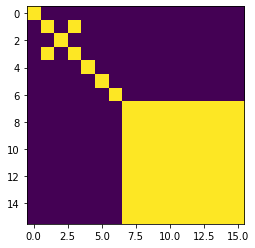

In [5]:
# for sample in old_samples:
#     sample: PianoRoll
#     if  sample.metadata.name =='11' :
#         break
# else:
#     raise Exception("sample not found")

# start_bar = 33
# for sample in dataset:
#     sample: PianoRoll
#     if sample.metadata.name == '52':
#         break
# else:
#     raise Exception("sample not found")
# sample = sample.slice((start_bar-1)*32,(start_bar-1+16)*32)

# path = '/screamlab/home/eri24816/compound-word-transformer/gen_midis/get_5.mid'
# sample = PianoRoll.from_midi(path)
# start_bar = 12
# sample = sample.slice((start_bar-1)*32,(start_bar-1+16)*32)
for i, sample in enumerate(a_samples[:10]):

    m=structural_dist_matrix(sample)
    #plt.imshow(-m,vmin=-6,vmax=0)
    plt.imshow(m<2)
    plt.savefig(f'temp/a/{i}.png')
#plt.colorbar()
print(sample)
print(m.mean())
sample.to_midi('temp.mid')

In [ ]:
def sim_distribution(samples:List[PianoRoll],diag=1):
    sims = []
    for sample in samples:
        sim_mat = structural_dist_matrix(sample)
        mask = nonempty_mask(sample)
        for sim, mask in zip(sim_mat.diagonal(diag).tolist(),mask.diagonal(diag).tolist()):
            if mask:    
                sims.append(sim)
    return sims


In [ ]:
sd = sim_distribution(c_samples,diag=2)
_=plt.hist(sd,bins=50)
sd = np.array(sd)
sd.mean(),sd.std(),sum(sd<2)/len(sd)


In [ ]:
sd = sim_distribution(b_samples,diag=2)
_=plt.hist(sd,bins=50)
sd = np.array(sd)
sd.mean(),sd.std(),sum(sd<2)/len(sd)

In [ ]:
sd = sim_distribution(a_samples,diag=1)
_=plt.hist(sd,bins=12)
sd = np.array(sd)
sd.mean(),sd.std(),sum(sd<2)/len(sd)

In [ ]:
sd = sim_distribution(
    [s.slice(32*0,32*16) for s in cp_samples]+
    [s.slice(32*16,32*32) for s in cp_samples]
,diag=2)
_=plt.hist(sd,bins=50)
sd = np.array(sd)
sd.mean(),sd.std(),sum(sd<2)/len(sd)

In [ ]:
sd = sim_distribution(
    [s.slice(32*16,32*32) for s in dataset[::10]]
,diag=2)
_=plt.hist(sd,bins=50)
sd = np.array(sd)
sd.mean(),sd.std(),sum(sd<2)/len(sd)

In [ ]:
sd = np.array(sd)
sum(sd<2)/len(sd)

In [ ]:
sda = sim_distribution(a_samples,diag=2)
sdb = sim_distribution(b_samples,diag=2)
sdc = sim_distribution(c_samples,diag=2)
sdcp = sim_distribution(cp_samples,diag=2)
sddata = sim_distribution([s.slice(32*16,32*32) for s in dataset[::10]],diag=2)

In [ ]:
# cumulative histogram
plt.hist(sda,bins=500,density=True,cumulative=True,histtype='step',label='a')
plt.hist(sdb,bins=500,density=True,cumulative=True,histtype='step',label='b')
plt.hist(sdc,bins=500,density=True,cumulative=True,histtype='step',label='c')
plt.hist(sdcp,bins=500,density=True,cumulative=True,histtype='step',label='cp')
plt.hist(sddata,bins=500,density=True,cumulative=True,histtype='step',label='data')
plt.legend()

In [79]:
import random

def load_pianorolls_from_folder(path):
    samples = []
    for file in os.listdir(path):
        samples.append(PianoRoll.from_midi(os.path.join(path, file)))
    return samples

# metrics based on dist matrix
def diag_entries_hist(dist_mats_and_masks,diag = 1):
    dists = []
    denom = 0
    for dist_mat, mask in dist_mats_and_masks:
        dist_mat:np.ndarray
        dists.extend(dist_mat.diagonal(diag)[mask.diagonal(diag)==1].tolist())
        denom+=sum(mask.diagonal(diag))
    #histogram
    histogram = [0.]*20
    for i in range(20):
        histogram[i] = sum([d<i+1 and d>=i for d in dists])

    for i in range(20):
        histogram[i]/=(denom+1e-8)

    return histogram, denom

def count_repititions(dist_mats_and_masks,diag=1,min_len=1,threshold=2):
    count = 0
    denom = 0
    for dist_mat, mask in dist_mats_and_masks:
        dist_mat:np.ndarray
        mask:np.ndarray
        dists = dist_mat.diagonal(diag)
        masks = mask.diagonal(diag)
        local_count = 0
        for i in range(len(dists)):
            if masks[i]:
                denom+=1
            if masks[i] and dists[i]<threshold:
                local_count+=1
            else:
                if local_count>=min_len:
                    count+=local_count
                local_count = 0
        if local_count>=min_len:
            count+=local_count
    return count/(denom+1e-8)

def analyze_stucture(songs:List[PianoRoll],samples_per_song=1):
    samples = []
    for song in songs:
        for i in range(samples_per_song):
            start = random.randint(0,max(0,song.duration//32-16))*32
            samples.append(song.slice(start,start+32*16))

    dist_mats_and_masks = []
    for sample in samples:
        dist_mat = structural_dist_matrix(sample)
        mask = nonempty_mask(sample)
        dist_mat[mask==0]=1000000
        dist_mats_and_masks.append((dist_mat,mask))

    diag_hist = [[]for _ in range(16)]
    diag_hist_denoms = [0.]*16
    for i in range(1,16):
        diag_hist[i], diag_hist_denoms[i] = diag_entries_hist(dist_mats_and_masks,diag=i)

    rep_counts = {}
    threshold = 2
    rep_params = {
        'AA':{'diag':1,'min_len':1},
        'A1A':{'diag':2,'min_len':1},
        'A3A':{'diag':4,'min_len':1},
        'AAA':{'diag':1,'min_len':2},
        'ABAB':{'diag':2,'min_len':2},
        'AB2AB':{'diag':4,'min_len':2},
    }
    for name, params in rep_params.items():
        rep_counts[name] = count_repititions(dist_mats_and_masks,diag=params['diag'],min_len=params['min_len'],threshold=threshold)

    return diag_hist, diag_hist_denoms, rep_counts

def analyze_stucture_from_folder(path,samples_per_song=1):
    samples = load_pianorolls_from_folder(path)
    return analyze_stucture(samples,samples_per_song)

def summarize(analyzed,threshold=2):
    diag_hist, diag_hist_denoms, rep_counts = analyzed
    summary = {}
    for diag in [1,2,4]:
        summary['diag'+str(diag)] = sum([diag_hist[diag][d] for d in range(threshold)])

    diag5plus = 0
    total_weight = 0
    for diag in range(5,16):
        weight = diag_hist_denoms[diag]
        diag5plus += sum([diag_hist[diag][d] for d in range(threshold)])*weight
        total_weight += weight
    summary['diag5+'] = diag5plus/total_weight
    
    for name, count in rep_counts.items():
        summary[name] = count
    return summary

In [80]:
results = {}
results['a'] = analyze_stucture(a_samples)
results['b'] = analyze_stucture(b_samples)
results['c'] = analyze_stucture(c_samples)

In [81]:
results['cp30'] = analyze_stucture_from_folder('/screamlab/home/eri24816/compound-word-transformer/workspace/uncond/cp-linear/gen_midis/30',samples_per_song=4)
results['cp32'] = analyze_stucture_from_folder('/screamlab/home/eri24816/compound-word-transformer/workspace/uncond/cp-linear/gen_midis/32',samples_per_song=4)
results['cp34'] = analyze_stucture_from_folder('/screamlab/home/eri24816/compound-word-transformer/workspace/uncond/cp-linear/gen_midis/34',samples_per_song=4)

In [82]:
results['dataset'] = analyze_stucture(dataset[::10],samples_per_song=1)

In [83]:
def bar_multiple(histograms,labels,xticks=None):
    x = np.arange(len(histograms[0]))
    width = 1/(len(histograms)+1)
    for i,histogram in enumerate(histograms):
        plt.bar(x+i*width,histogram,width,label=labels[i])
    if xticks is not None:
        plt.xticks(x,xticks)
    plt.legend()

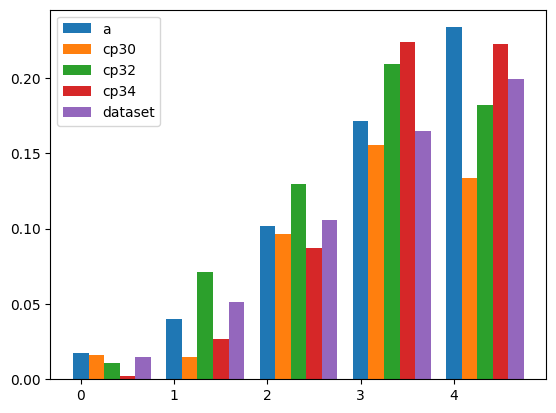

In [84]:
# plt.bar(np.arange(12)-0.2,results['a'][0][1][:12],width=0.3,label='a')
# plt.bar(np.arange(12)+0.1,results['cp'][0][1][:12],width=0.3,label='cp')
# plt.bar(np.arange(12)+0.4,results['dataset'][0][1][:12],width=0.3,label='dataset')
# plt.legend()
max_x = 5
diag = 3
bar_multiple([results['a'][0][diag][:max_x],results['cp30'][0][diag][:max_x],results['cp32'][0][diag][:max_x],results['cp34'][0][diag][:max_x],results['dataset'][0][diag][:max_x]],['a','cp30','cp32','cp34','dataset'])

plt.rcdefaults()

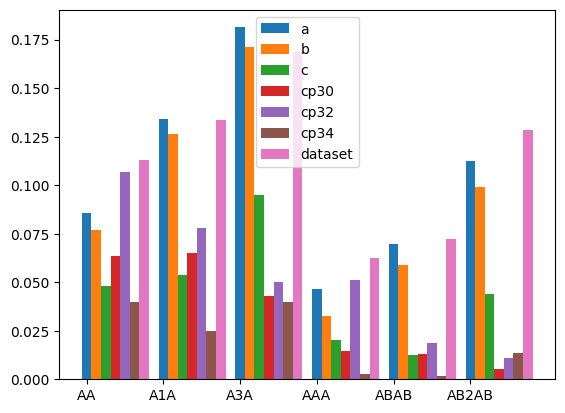

In [85]:
bar_multiple([
    results['a'][2].values(),
    results['b'][2].values(),
    results['c'][2].values(),
    results['cp30'][2].values(),
    results['cp32'][2].values(),
    results['cp34'][2].values(),
    results['dataset'][2].values()
              ],['a','b','c','cp30','cp32','cp34','dataset'],xticks=['AA','A1A','A3A','AAA','ABAB','AB2AB'])

In [86]:
summarize(results['a'])

{'diag1': 0.08542713567731876,
 'diag2': 0.13406292749474608,
 'diag4': 0.1813804173325621,
 'diag5+': 0.04644890620183303,
 'AA': 0.08542713567731876,
 'A1A': 0.13406292749474605,
 'A3A': 0.1813804173325621,
 'AAA': 0.04648241205971756,
 'ABAB': 0.0697674418595107,
 'AB2AB': 0.11235955055999423}

In [87]:
summarize(results['cp32'])

{'diag1': 0.10692669804904556,
 'diag2': 0.07791279485290985,
 'diag4': 0.04999999999957627,
 'diag5+': 0.037584525868273204,
 'AA': 0.10692669804904556,
 'A1A': 0.07791279485290985,
 'A3A': 0.04999999999957627,
 'AAA': 0.05110961667753121,
 'ABAB': 0.01858470335940969,
 'AB2AB': 0.01101694915244901}

In [88]:
summarize(results['dataset'])

{'diag1': 0.11279193205914864,
 'diag2': 0.13342816500673277,
 'diag4': 0.1688829787228428,
 'diag5+': 0.04433647130249441,
 'AA': 0.11279193205914864,
 'A1A': 0.1334281650067328,
 'A3A': 0.1688829787228428,
 'AAA': 0.06263269639049196,
 'ABAB': 0.07226173541942457,
 'AB2AB': 0.1286569148931893}

In [1]:
def release_pedal_n_times_a_bar(midi, n):
    for note in midi.instruments[0].notes:
        seg_len = 1920//n
        seg_idx = note.start//seg_len
        if note.end>seg_len*(seg_idx+1):
            note.end = int(seg_len*(seg_idx+1))

from chorder import Dechorder
import miditoolkit
file = "/screamlab/home/eri24816/improved-diffusion/analysis/samples/a42_sampled/2_PianoRoll Bar 000 - 016 of ('a42', 0, 2).mid"
midi = miditoolkit.midi.parser.MidiFile(file)
release_pedal_n_times_a_bar(midi, 2)
chords = Dechorder.dechord(midi)
print(*[str(c) for c in chords])

CM CM CM CM CM CM CM/G CM/G CM CM FM FM Am/C Am/C Fsus2 Fsus2 Am Am CM/G CM/G CM CM Csus2 Csus2 CM/E CM/E CM/E CM/E Am7 Am7 CM/E CM/E Am Am Dm7 Dm7 Dm7 Dm7 Am Am FM FM FM FM Em7/G Em7/G Em7/D Em7/D CM CM CM CM CM7 CM7 CM CM Fm7 Fm7 FM FM FM/C FM/C CM CM None


In [2]:
chords = Dechorder.dechord(midi)
print(*[str(c.quality) for c in chords])

M M M M M M M M M M M M m m sus2 sus2 m m M M M M sus2 sus2 M M M M m7 m7 M M m m m7 m7 m7 m7 m m M M M M m7 m7 m7 m7 M M M M M7 M7 M M m7 m7 M M M M M M None


In [9]:
chords[-1].root()==None

True

In [33]:
for note in midi.instruments[0].notes:
    seg_len = 1920//2
    seg_idx = note.start//seg_len
    if note.end>seg_len*(seg_idx+1):
        note.end = int(seg_len*(seg_idx+1))


In [10]:
chords_prog_str = [1,1,5,5,4,4,4,3,2,5,5]
for i in range(len(chords_prog_str)-1,0,-1):
    if chords_prog_str[i] == chords_prog_str[i-1]:
        del chords_prog_str[i]

In [27]:
chords[-1].root()==None

True

In [28]:
from chord import get_ngram_count
chord_dist = get_ngram_count([chords[:-1]],3)

In [39]:
def bar_multiple(sequences,labels,xticks=None):
    x = np.arange(len(sequences[0]))
    width = 1/(len(sequences)+1)
    for i,histogram in enumerate(sequences):
        plt.bar(x+i*width,histogram,width,label=labels[i])
    if xticks is not None:
        plt.xticks(x,xticks)
    plt.legend()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
chord_dist_sorted = sorted(chord_dist.items(),key=lambda x:x[1],reverse=True)
bar_multiple([x[0].replace(' ','\n') for x in chord_dist_sorted],[x[1] for x in chord_dist_sorted])

NameError: name 'chord_dist' is not defined

In [32]:
from collections import defaultdict
'afe' in defaultdict(float)

False

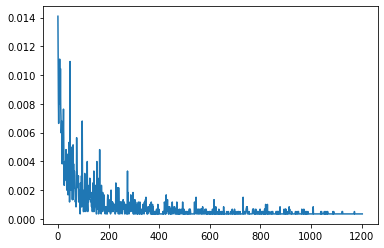

In [8]:
from chord import load_all_midi, get_chord_prog, get_ngram_count
dataset_path = '../../analysis/samples/test_sampled'
sample_path = '../../analysis/samples/a42_sampled'
dataset = load_all_midi(dataset_path)
samples = load_all_midi(sample_path)
dataset_chord_progs = [get_chord_prog(midi) for midi in dataset]
sample_chord_progs = [get_chord_prog(midi) for midi in samples]

n=3
dataset_chord_distribution = get_ngram_count(dataset_chord_progs,n)
sample_chord_distribution = get_ngram_count(sample_chord_progs,n)

dataset_chord_dist_sorted = sorted(dataset_chord_distribution.items(),key=lambda x:x[1],reverse=True)
sample_chord_dist_sorted = sorted(sample_chord_distribution.items(),key=lambda x:dataset_chord_distribution[x[0]],reverse=True)

plt.plot([x[1] for x in sample_chord_dist_sorted])

In [6]:
from chord import load_all_midi, get_chord_prog, get_ngram_count
dataset_path = '../../analysis/samples/test_sampled'
sample_path = '../../analysis/samples/32n_sampled'
dataset = load_all_midi(dataset_path)
samples = load_all_midi(sample_path)
dataset_chord_progs = [get_chord_prog(midi) for midi in dataset]
sample_chord_progs = [get_chord_prog(midi) for midi in samples]

n=3
dataset_ngram_count = get_ngram_count(dataset_chord_progs,n)
sample_ngram_count = get_ngram_count(sample_chord_progs,n)

dataset_chord_dist_sorted = sorted(dataset_chord_distribution.items(),key=lambda x:x[1],reverse=True)
sample_chord_dist_sorted = sorted(sample_chord_distribution.items(),key=lambda x:dataset_chord_distribution[x[0]],reverse=True)

plt.plot([x[1] for x in sample_chord_dist_sorted])

NameError: name 'plt' is not defined

In [44]:
freq=0
for i,(k,v) in enumerate(dataset_chord_dist_sorted):
    if k not in sample_chord_distribution:
        freq+=v
        print(i,k,v)
print(freq)

133 Dm D Dm 0.0016542597187758478
155 G# Bb C 0.001488833746898263
194 C G# Bb 0.0011579818031430935
205 F C G# 0.0009925558312655087
207 A C D 0.0009925558312655087
218 C Dm A 0.0009925558312655087
219 Dm A C 0.0009925558312655087
227 E A E 0.0009925558312655087
232 Dm G Dm 0.0009925558312655087
238 F Bb Eb 0.0009925558312655087
239 Bb Eb Cm 0.0009925558312655087
240 Eb Cm Fm 0.0009925558312655087
259 E Dm Am 0.0008271298593879239
280 Am Bb Am 0.0008271298593879239
288 C Gm Bb 0.0006617038875103391
289 D F E 0.0006617038875103391
290 C F Bb 0.0006617038875103391
295 F G Gm 0.0006617038875103391
297 Am B C 0.0006617038875103391
304 C# G# Bbm 0.0006617038875103391
306 A Am Bb 0.0006617038875103391
312 D A E 0.0006617038875103391
323 E F Em 0.0006617038875103391
327 Am A E 0.0006617038875103391
333 Bm D G 0.0006617038875103391
334 F Dm Fm 0.0006617038875103391
336 F Fm C 0.0006617038875103391
337 C G# F 0.0006617038875103391
338 F A Dm 0.0006617038875103391
339 Am Dm G# 0.000661703887510

In [23]:
sample_chord_distribution

defaultdict(float,
            {'D Am A': 0.0010362694300518134,
             'Am A F': 0.002901554404145078,
             'A F C': 0.0018652849740932642,
             'F C A': 0.004766839378238342,
             'C A C': 0.0010362694300518134,
             'A C E': 0.0004145077720207254,
             'C E Em': 0.0004145077720207254,
             'E Em A': 0.0004145077720207254,
             'Em A Am': 0.002694300518134715,
             'A Am A': 0.003937823834196891,
             'Am A Am': 0.004766839378238342,
             'A Am C': 0.001243523316062176,
             'Am C G': 0.004352331606217617,
             'C G F': 0.004145077720207254,
             'G F C': 0.007253886010362694,
             'F C F': 0.008290155440414507,
             'C F Em': 0.004352331606217617,
             'F Em G': 0.0016580310880829016,
             'Em G Am': 0.003937823834196891,
             'G Am F': 0.00766839378238342,
             'Am F C': 0.012849740932642488,
             'C F C': 0.0174093264

In [5]:
import numpy as np

0.2*np.log(0.0002/(1/1000))

-0.3218875824868201